In [ ]:
%load_ext autoreload
%autoreload 2
import datajoint as dj
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
dj.config["filepath_checksum_size_limit"] = 1000
import os
from ms_stim_analysis.AnalysisTables.sequence_compression import CompressionIndexParams, CompressionIndexSelection, CompressionIndex
from ms_stim_analysis.Analysis.utils import filter_opto_data
from spyglass.decoding.v1.sorted_spikes import SortedSpikesDecodingV1


[2025-09-04 09:00:36,607][INFO]: DataJoint 0.14.6 connected to sambray@lmf-db.cin.ucsf.edu:3306


compression_index_params_name,filter_speed,min_running_spikes,pf_bin_size cm,pf_peak_ratio,delay_range ms,delay_smoothing ms,min_coincident_spikes,graph_distance whether to calculate the graph distance between place fields,delay_distance minimum distance between peaks in the delay histogram,smoothing_sigma sigma for gaussian smoothing of the delay histogram defaults to 1/2 delay_smoothing
0720slow_graph_distance,10.0,100,5.0,10.0,1500,1000,30,1,2000,250.0
0720v2_slow_graph_distance,10.0,100,5.0,10.0,1500,300,30,1,2000,10000.0
0720v3_permissive_slow,10.0,100,5.0,1.0,1500,1000,30,0,2000,500.0
0720v3_slow,10.0,100,5.0,10.0,1500,1000,30,0,2000,500.0
0720v3_slow_graph_distance,10.0,100,5.0,10.0,1500,1000,30,1,2000,500.0
0720v4_permissive_slow,10.0,100,5.0,1.0,1500,1000,30,0,2000,50000.0
cross_method_graph_distance,10.0,100,5.0,1.0,1000,10,30,1,80,nan
default,10.0,100,5.0,10.0,100,33,30,0,80,nan
default_graph_distance,10.0,100,5.0,10.0,100,33,30,1,80,nan
fast,10.0,100,5.0,10.0,150,33,30,0,100,nan


In [ ]:
# # Logging for database export. Not necessary for replication

# from spyglass.common.common_usage import Export, ExportSelection

# paper_key = {"paper_id": "ms_stim_analysis"}


# analysis_id = "peak_delay_times_lineartrack"

# # (ExportSelection & {**paper_key, "analysis_id": analysis_id}).delete()

# ExportSelection().start_export(**paper_key, analysis_id=analysis_id)

[15:44:07][INFO] Spyglass: Export 54 in progress. Starting new.
[15:44:07][INFO] Spyglass: Starting {'export_id': 54}


In [ ]:
exclude_simultaneous = False
track = "lineartrack"
dlc_pos = track != "lineartrack"

results = {}


from ms_stim_analysis.Style.style_guide import animal_style

animal_list = animal_style.index.values
animal_list = [
    x
    for x in animal_list
    if x not in ["control", "transfected", "Banner", "Odins", "Dan"]
]
animal_list.extend(["control", "transfected"])

# animal_list = ["Yoshi", "Winnie"]
# animal_list = ["transfected", "control"]

In [ ]:
min_spikes_fast = 10
min_spikes_slow = 100

# min_spikes_slow = 10
# min_spikes_fast = 10

results = {}

for animal in animal_list:
    if animal in results:
        continue
    dataset_key = {
        "animal": animal,
        "targeted_phase": 90,
        "track_type": track,
        "min_pulse_length": 20,
        "laser_power": 77,
    }
    dataset = filter_opto_data(dataset_key)

    query = CompressionIndex() & dataset.proj(
        decoding_interval="interval_list_name"
    ).fetch("KEY")
    # slow_query = query & "compression_index_params_name LIKE 'permissive_slow%'"
    fast_query = query & "compression_index_params_name LIKE 'permissive_default%'"
    slow_query = query & "compression_index_params_name LIKE '0720v4_permissive_slow%'"
    # fast_query = query & "compression_index_params_name LIKE 'default%'"

    query = query - "sorted_spikes_group_name LIKE '%full_day%'"
    # query = query & "encoding_interval LIKE '%valid times'"
    control_slow_query = slow_query & "encoding_interval LIKE '%control_interval'"
    test_slow_query = slow_query & "encoding_interval LIKE '%test_interval'"
    control_fast_query = fast_query & "encoding_interval LIKE '%control_interval'"
    test_fast_query = fast_query & "encoding_interval LIKE '%test_interval'"

    control_slow_df = control_slow_query.fetch_delays_dataframes()
    test_slow_df = test_slow_query.fetch_delays_dataframes()
    control_fast_df = control_fast_query.fetch_delays_dataframes()
    test_fast_df = test_fast_query.fetch_delays_dataframes()
    # raise ValueError()
    if any(
        [
            len(df) == 0
            for df in [control_fast_df, control_slow_df, test_fast_df, test_slow_df]
        ]
    ):
        # raise ValueError("empty array")
        continue

    control_slow_df = control_slow_df[control_slow_df.n_coincidients >= min_spikes_slow]
    test_slow_df = test_slow_df[test_slow_df.n_coincidients >= min_spikes_slow]
    control_fast_df = control_fast_df[control_fast_df.n_coincidients >= min_spikes_fast]
    test_fast_df = test_fast_df[test_fast_df.n_coincidients >= min_spikes_fast]

    merged_control_df = pd.merge(
        control_slow_df,
        control_fast_df,
        on=["s_id_1", "s_id_2"],
        suffixes=("_slow", "_fast"),
    )
    merged_test_df = pd.merge(
        test_slow_df,
        test_fast_df,
        on=["s_id_1", "s_id_2"],
        suffixes=("_slow", "_fast"),
    )
    results_i = {
        "control": merged_control_df,
        "test": merged_test_df,
    }

    results[animal] = results_i

[15:44:20][WARNING] Spyglass: Cannot export log join for
<class 'ms_stim_analysis.AnalysisTables.ms_opto_stim_protocol.OptoStimProtocolLaser'>


datasets: 2


[2025-09-04 15:44:36,335][WARNING]: Skipped checksum for file with hash: 3a46cb74-db2a-9465-1917-3c818e4d2b77, and path: /stelmo/nwb/analysis/Winnie20220717/Winnie20220717_TUDP51NXPD.nwb
[2025-09-04 15:44:36,342][WARNING]: Skipped checksum for file with hash: 3a46cb74-db2a-9465-1917-3c818e4d2b77, and path: /stelmo/nwb/analysis/Winnie20220717/Winnie20220717_TUDP51NXPD.nwb
[2025-09-04 15:44:36,406][WARNING]: Skipped checksum for file with hash: 8e2371d8-0dab-c2a9-d6fd-37a8c441cd0d, and path: /stelmo/nwb/analysis/Winnie20220717/Winnie20220717_2EGPFHHFVG.nwb
[2025-09-04 15:44:36,412][WARNING]: Skipped checksum for file with hash: 8e2371d8-0dab-c2a9-d6fd-37a8c441cd0d, and path: /stelmo/nwb/analysis/Winnie20220717/Winnie20220717_2EGPFHHFVG.nwb
[2025-09-04 15:44:36,472][WARNING]: Skipped checksum for file with hash: af81198a-8607-12f8-20da-7bf58a32dda9, and path: /stelmo/nwb/analysis/Winnie20220717/Winnie20220717_G9MEFZ70CU.nwb
[2025-09-04 15:44:36,478][WARNING]: Skipped checksum for file wit

datasets: 2


[2025-09-04 15:46:26,011][WARNING]: Skipped checksum for file with hash: 2a049443-09bb-8918-ffd4-bbfba5b0a373, and path: /stelmo/nwb/analysis/Frodo20230810/Frodo20230810_N13VTG5KEM.nwb
[2025-09-04 15:46:26,017][WARNING]: Skipped checksum for file with hash: 2a049443-09bb-8918-ffd4-bbfba5b0a373, and path: /stelmo/nwb/analysis/Frodo20230810/Frodo20230810_N13VTG5KEM.nwb
[2025-09-04 15:46:26,078][WARNING]: Skipped checksum for file with hash: 851e421f-fc3a-8077-fc2d-2eb4f766f42a, and path: /stelmo/nwb/analysis/Frodo20230811/Frodo20230811_89BD35DW60.nwb
[2025-09-04 15:46:26,084][WARNING]: Skipped checksum for file with hash: 851e421f-fc3a-8077-fc2d-2eb4f766f42a, and path: /stelmo/nwb/analysis/Frodo20230811/Frodo20230811_89BD35DW60.nwb
[2025-09-04 15:46:26,140][WARNING]: Skipped checksum for file with hash: 5eddd088-048c-098a-5e23-8db284b95fc6, and path: /stelmo/nwb/analysis/Frodo20230811/Frodo20230811_BOP0DXZX7L.nwb
[2025-09-04 15:46:26,145][WARNING]: Skipped checksum for file with hash: 5e

datasets: 2


[2025-09-04 15:49:05,150][WARNING]: Skipped checksum for file with hash: 8c6c30eb-fee6-0c28-89e5-157bfa09a20c, and path: /stelmo/nwb/analysis/Totoro20220607/Totoro20220607_0W21CQUBEZ.nwb
[2025-09-04 15:49:05,156][WARNING]: Skipped checksum for file with hash: 8c6c30eb-fee6-0c28-89e5-157bfa09a20c, and path: /stelmo/nwb/analysis/Totoro20220607/Totoro20220607_0W21CQUBEZ.nwb
[2025-09-04 15:49:05,214][WARNING]: Skipped checksum for file with hash: 09eb234e-29e6-f6e9-0028-75ab6b454460, and path: /stelmo/nwb/analysis/Totoro20220607/Totoro20220607_7HM68IPFKS.nwb
[2025-09-04 15:49:05,220][WARNING]: Skipped checksum for file with hash: 09eb234e-29e6-f6e9-0028-75ab6b454460, and path: /stelmo/nwb/analysis/Totoro20220607/Totoro20220607_7HM68IPFKS.nwb
[2025-09-04 15:49:18,273][WARNING]: Skipped checksum for file with hash: bd90aada-695a-fa20-201c-be4b0fd3540d, and path: /stelmo/nwb/analysis/Totoro20220607/Totoro20220607_EJLGFBNT45.nwb
[2025-09-04 15:49:18,280][WARNING]: Skipped checksum for file wit

datasets: 2


[2025-09-04 15:50:08,422][WARNING]: Skipped checksum for file with hash: 85d40392-455f-ca0e-acae-e33cab3f13f2, and path: /stelmo/nwb/analysis/Wallie20220914/Wallie20220914_HBT39XINTN.nwb
[2025-09-04 15:50:08,430][WARNING]: Skipped checksum for file with hash: 85d40392-455f-ca0e-acae-e33cab3f13f2, and path: /stelmo/nwb/analysis/Wallie20220914/Wallie20220914_HBT39XINTN.nwb
[2025-09-04 15:50:08,495][WARNING]: Skipped checksum for file with hash: 9eb476db-8691-5475-3e9c-801db791914d, and path: /stelmo/nwb/analysis/Wallie20220914/Wallie20220914_XUIKBS2GY8.nwb
[2025-09-04 15:50:08,503][WARNING]: Skipped checksum for file with hash: 9eb476db-8691-5475-3e9c-801db791914d, and path: /stelmo/nwb/analysis/Wallie20220914/Wallie20220914_XUIKBS2GY8.nwb
[2025-09-04 15:50:21,516][WARNING]: Skipped checksum for file with hash: 9286490f-11f3-13a6-8840-c4e60c2a5d74, and path: /stelmo/nwb/analysis/Wallie20220914/Wallie20220914_7B9U694AGM.nwb
[2025-09-04 15:50:21,525][WARNING]: Skipped checksum for file wit

datasets: 2


[2025-09-04 15:51:11,741][WARNING]: Skipped checksum for file with hash: 412c5683-8eb6-e667-24ec-6b8818909098, and path: /stelmo/nwb/analysis/Olive20220707/Olive20220707_QQ3BXPIIIB.nwb
[2025-09-04 15:51:11,749][WARNING]: Skipped checksum for file with hash: 412c5683-8eb6-e667-24ec-6b8818909098, and path: /stelmo/nwb/analysis/Olive20220707/Olive20220707_QQ3BXPIIIB.nwb
[2025-09-04 15:51:11,812][WARNING]: Skipped checksum for file with hash: 09d270d9-2334-281c-808a-649c0151e590, and path: /stelmo/nwb/analysis/Olive20220707/Olive20220707_L4B9SQ0H7D.nwb
[2025-09-04 15:51:11,820][WARNING]: Skipped checksum for file with hash: 09d270d9-2334-281c-808a-649c0151e590, and path: /stelmo/nwb/analysis/Olive20220707/Olive20220707_L4B9SQ0H7D.nwb
[2025-09-04 15:51:24,383][WARNING]: Skipped checksum for file with hash: c7475b87-d3cc-6324-f8bc-b9d004de2aaf, and path: /stelmo/nwb/analysis/Olive20220707/Olive20220707_FFHD18N8SZ.nwb
[2025-09-04 15:51:24,390][WARNING]: Skipped checksum for file with hash: c7

datasets: 2


[2025-09-04 15:52:13,782][WARNING]: Skipped checksum for file with hash: 4456b194-dfe7-1c7a-32f7-aef9592c23e5, and path: /stelmo/nwb/analysis/Yoshi20220513/Yoshi20220513_7O1A9U16BQ.nwb
[2025-09-04 15:52:13,789][WARNING]: Skipped checksum for file with hash: 4456b194-dfe7-1c7a-32f7-aef9592c23e5, and path: /stelmo/nwb/analysis/Yoshi20220513/Yoshi20220513_7O1A9U16BQ.nwb
[2025-09-04 15:52:13,852][WARNING]: Skipped checksum for file with hash: d3ce55d7-21ec-5b1a-cf95-798c38b6c489, and path: /stelmo/nwb/analysis/Yoshi20220513/Yoshi20220513_JLA3XUB6PU.nwb
[2025-09-04 15:52:13,860][WARNING]: Skipped checksum for file with hash: d3ce55d7-21ec-5b1a-cf95-798c38b6c489, and path: /stelmo/nwb/analysis/Yoshi20220513/Yoshi20220513_JLA3XUB6PU.nwb
[2025-09-04 15:52:26,599][WARNING]: Skipped checksum for file with hash: a4240360-f703-c015-7dac-0a7c2a0a3b0a, and path: /stelmo/nwb/analysis/Yoshi20220513/Yoshi20220513_Y1QDSCG5FC.nwb
[2025-09-04 15:52:26,606][WARNING]: Skipped checksum for file with hash: a4

datasets: 1


[2025-09-04 15:53:15,563][WARNING]: Skipped checksum for file with hash: bdbc0d27-7e72-3eeb-1519-b1cb83e05b5d, and path: /stelmo/nwb/analysis/Bilbo20230725/Bilbo20230725_5AGPKULJG2.nwb
[2025-09-04 15:53:15,570][WARNING]: Skipped checksum for file with hash: bdbc0d27-7e72-3eeb-1519-b1cb83e05b5d, and path: /stelmo/nwb/analysis/Bilbo20230725/Bilbo20230725_5AGPKULJG2.nwb
[2025-09-04 15:53:28,266][WARNING]: Skipped checksum for file with hash: 3ead7431-650e-7a03-5a5d-177f212cdc6b, and path: /stelmo/nwb/analysis/Bilbo20230725/Bilbo20230725_DRT5BUQKV0.nwb
[2025-09-04 15:53:28,273][WARNING]: Skipped checksum for file with hash: 3ead7431-650e-7a03-5a5d-177f212cdc6b, and path: /stelmo/nwb/analysis/Bilbo20230725/Bilbo20230725_DRT5BUQKV0.nwb
[2025-09-04 15:53:40,923][WARNING]: Skipped checksum for file with hash: 351cebaa-a959-ea06-685d-d2fd20d58bea, and path: /stelmo/nwb/analysis/Bilbo20230725/Bilbo20230725_I3OOJX22SJ.nwb
[2025-09-04 15:53:40,931][WARNING]: Skipped checksum for file with hash: 35

datasets: 7


[2025-09-04 15:54:25,015][WARNING]: Skipped checksum for file with hash: bdbc0d27-7e72-3eeb-1519-b1cb83e05b5d, and path: /stelmo/nwb/analysis/Bilbo20230725/Bilbo20230725_5AGPKULJG2.nwb
[2025-09-04 15:54:25,022][WARNING]: Skipped checksum for file with hash: bdbc0d27-7e72-3eeb-1519-b1cb83e05b5d, and path: /stelmo/nwb/analysis/Bilbo20230725/Bilbo20230725_5AGPKULJG2.nwb
[2025-09-04 15:54:25,085][WARNING]: Skipped checksum for file with hash: 412c5683-8eb6-e667-24ec-6b8818909098, and path: /stelmo/nwb/analysis/Olive20220707/Olive20220707_QQ3BXPIIIB.nwb
[2025-09-04 15:54:25,092][WARNING]: Skipped checksum for file with hash: 412c5683-8eb6-e667-24ec-6b8818909098, and path: /stelmo/nwb/analysis/Olive20220707/Olive20220707_QQ3BXPIIIB.nwb
[2025-09-04 15:54:25,151][WARNING]: Skipped checksum for file with hash: 09d270d9-2334-281c-808a-649c0151e590, and path: /stelmo/nwb/analysis/Olive20220707/Olive20220707_L4B9SQ0H7D.nwb
[2025-09-04 15:54:25,158][WARNING]: Skipped checksum for file with hash: 09

datasets: 11


[2025-09-04 15:55:11,745][WARNING]: Skipped checksum for file with hash: 2a049443-09bb-8918-ffd4-bbfba5b0a373, and path: /stelmo/nwb/analysis/Frodo20230810/Frodo20230810_N13VTG5KEM.nwb
[2025-09-04 15:55:11,752][WARNING]: Skipped checksum for file with hash: 2a049443-09bb-8918-ffd4-bbfba5b0a373, and path: /stelmo/nwb/analysis/Frodo20230810/Frodo20230810_N13VTG5KEM.nwb
[2025-09-04 15:55:11,810][WARNING]: Skipped checksum for file with hash: 851e421f-fc3a-8077-fc2d-2eb4f766f42a, and path: /stelmo/nwb/analysis/Frodo20230811/Frodo20230811_89BD35DW60.nwb
[2025-09-04 15:55:11,816][WARNING]: Skipped checksum for file with hash: 851e421f-fc3a-8077-fc2d-2eb4f766f42a, and path: /stelmo/nwb/analysis/Frodo20230811/Frodo20230811_89BD35DW60.nwb
[2025-09-04 15:55:11,867][WARNING]: Skipped checksum for file with hash: 5eddd088-048c-098a-5e23-8db284b95fc6, and path: /stelmo/nwb/analysis/Frodo20230811/Frodo20230811_BOP0DXZX7L.nwb
[2025-09-04 15:55:11,873][WARNING]: Skipped checksum for file with hash: 5e

## Distribution delay 

In [22]:
from scipy.stats import linregress


def get_max_fast_peak_delay(row):
    fast_bins = np.arange(-200, 199) + 0.5
    ind_relevant = np.where(np.abs(fast_bins) <= 100)[0]
    peak_ind = np.argmax(row.cross_corr_fast[ind_relevant])
    return fast_bins[ind_relevant][peak_ind]

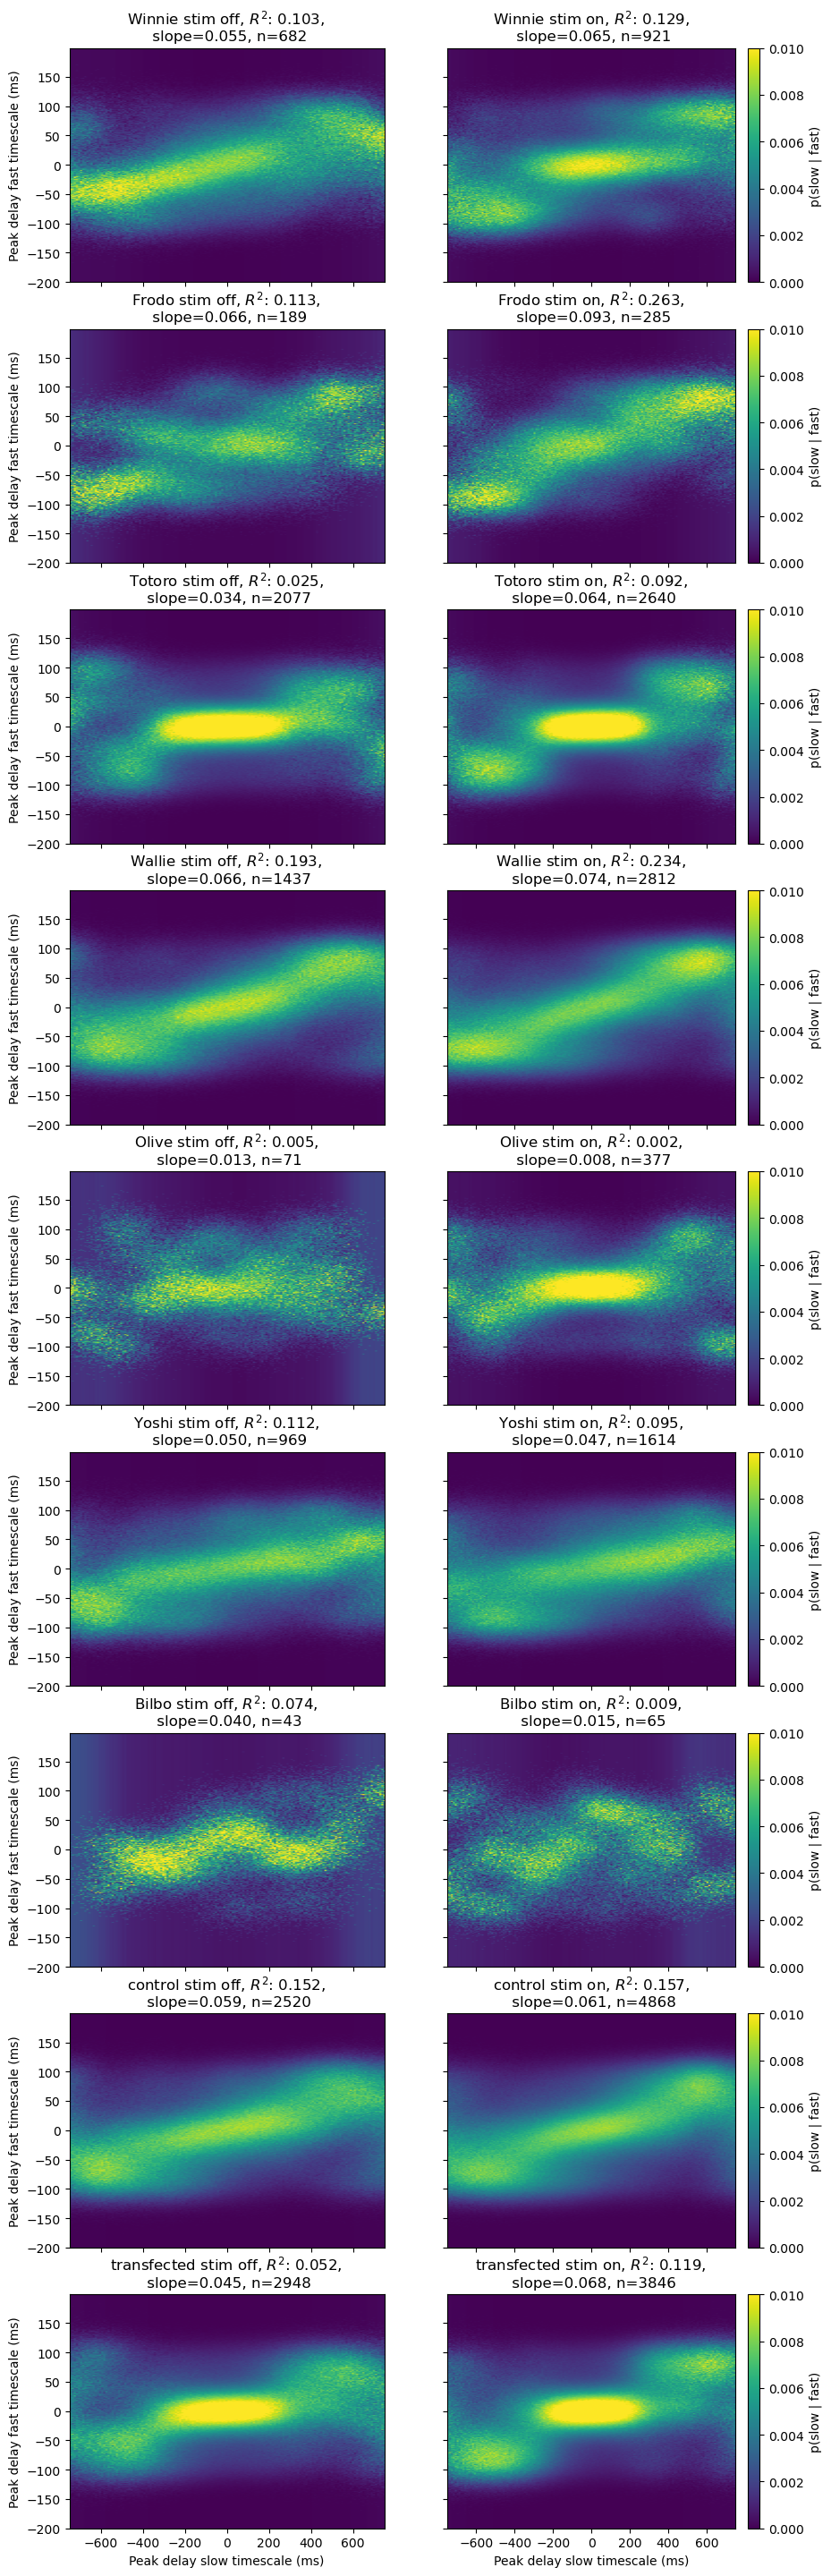

In [24]:
import pandas as pd
import matplotlib.pyplot as plt

upsample = 3000
sigma_slow = 100
sigma_fast = 20

log = False
standardize_orders = False
modulo_shift = 0
slow_bin_size = 10
fast_bin_size = 1

plot_ridge = False
long_timescale_thresh = 200

correlation_range = 750

# slow_bin_size = 16
# fast_bin_size = 6
# slow_bin_size = 2
# fast_bin_size = 1

heatmap_results = {}
fast_distribution = {}
slow_distribution = {}
counts = {}
long_timescale_counts = {}
slopes = {}
correlations = {}

fig, ax = plt.subplots(
    ncols=2,
    nrows=len(results),
    sharex=True,
    sharey=True,
    figsize=(10, 4 * len(results)),
)
for a, animal in zip(ax, results.keys()):
    heatmap_results[animal] = {}
    fast_distribution[animal] = {}
    slow_distribution[animal] = {}
    counts[animal] = {}
    long_timescale_counts[animal] = {}
    correlations[animal] = {}
    slopes[animal] = {}

    merged_control_df = results[animal]["control"].copy()
    merged_test_df = results[animal]["test"].copy()

    # merged_control_df = merged_control_df[merged_control_df.n_coincidients_fast >= 100]
    # merged_test_df = merged_test_df[merged_test_df.n_coincidients_fast >= 100]

    lim_x = correlation_range + 1
    # lim_x = 401
    # lim_x = 201
    if standardize_orders:
        bx = np.arange(0, lim_x, slow_bin_size)
    else:
        bx = np.arange(-lim_x, lim_x, slow_bin_size)

    # by = np.arange(-130, 130, fast_bin_size)
    by = np.arange(-200, 200, fast_bin_size)

    for a_i, merged_df, cond in zip(
        a, [merged_control_df, merged_test_df], ["stim off", "stim on"]
    ):
        slow_val = merged_df.peak_delay_slow.values.copy()
        # fast_val = merged_df.peak_delay_fast.values.copy()
        fast_val = np.array(
            [get_max_fast_peak_delay(row) for _, row in merged_df.iterrows()]
        )

        raw_slow_val = slow_val.copy()
        raw_fast_val = fast_val.copy()
        counts[animal][cond] = len(merged_df)
        long_timescale_counts[animal][cond] = np.sum(
            np.abs(slow_val > long_timescale_thresh)
        )

        if upsample > 1:
            slow_val = [x for x in slow_val for _ in range(upsample)]
            fast_val = [x for x in fast_val for _ in range(upsample)]
            slow_val = np.array(slow_val) + np.random.normal(
                0, sigma_slow, len(slow_val)
            )
            fast_val = np.array(fast_val) + np.random.normal(
                0, sigma_fast, len(fast_val)
            )

        if standardize_orders:
            ind = np.where(slow_val < 0)[0]
            slow_val[ind] = -slow_val[ind]
            fast_val[ind] = -fast_val[ind]

        if modulo_shift:
            ind = np.where(np.abs(slow_val) < 200)[0]
            steps = np.arange(0, 500, modulo_shift)
            sub_outer = np.subtract.outer(
                slow_val,
                steps,
            )
            min_offset = np.argmin(np.abs(sub_outer), axis=1)
            slow_val = np.array(
                [sub_outer[i, min_offset[i]] for i in range(len(min_offset))]
            )
            slow_val = slow_val[ind]
            fast_val = fast_val[ind]

        dist_slow = np.histogram(slow_val, bins=bx)[0]
        dist_slow = dist_slow / dist_slow.sum()
        slow_distribution[animal][cond] = dist_slow
        dist_fast = np.histogram(fast_val, bins=by)[0]
        dist_fast = dist_fast / dist_fast.sum()
        fast_distribution[animal][cond] = dist_fast

        H, bx, by = np.histogram2d(slow_val, fast_val, bins=(bx, by))

        H = H + 1
        # H = H / H.sum()
        H = H / H.sum(axis=1)[:, None]
        if log:
            H = np.log10(H + 1e-10)  # Log transform to visualize better
            a_i.imshow(
                H.T,
                origin="lower",
                extent=(bx[0], bx[-1], by[0], by[-1]),
                # cmap="hot",
                aspect="auto",
                clim=(-2, -1),
            )
        else:
            a_i.imshow(
                H.T,
                origin="lower",
                extent=(bx[0], bx[-1], by[0], by[-1]),
                # cmap="hot",
                aspect="auto",
                clim=(0, 0.01),
            )
        if plot_ridge:
            a_i.plot(bx[1:], by[np.argmax(H, axis=1)], c="cyan")
            a_i.scatter(bx[1:], by[np.argmax(H, axis=1)], c="cyan", s=10, alpha=1)

        ind_corr = np.logical_and(
            np.abs(raw_slow_val) <= correlation_range, np.abs(raw_fast_val) <= 99
        )

        corr = np.corrcoef(
            raw_slow_val[ind_corr],
            raw_fast_val[ind_corr],
        )[0, 1]
        correlations[animal][cond] = corr
        regress = linregress(raw_slow_val[ind_corr], raw_fast_val[ind_corr])
        slope = regress.slope
        slopes[animal][cond] = slope
        a_i.set_title(
            f"{animal} {cond}, $R^2$: {corr**2:.3f}, \n slope={slope:.3f}, n={counts[animal][cond]}"
        )

        heatmap_results[animal][cond] = H

# plt.colorbar(label='Counts')
for i, a_col in enumerate(ax[:, 1]):
    im = a_col.images[0] if a_col.images else None
    if im is not None:
        plt.colorbar(
            im,
            ax=a_col,
            orientation="vertical",
            fraction=0.046,
            pad=0.04,
            label="p(slow | fast)",
        )


lim = correlation_range
if modulo_shift:
    plt.xlim(-modulo_shift // 2, modulo_shift // 2)
elif standardize_orders:
    plt.xlim(0, lim)
else:
    plt.xlim(-lim, lim)
for a in ax[-1, :]:
    # a.set_ylim(-100, 100)
    xlabel = "Peak delay slow timescale (ms)"
    if modulo_shift:
        xlabel = f"Peak delay slow timescale (ms) modulo {modulo_shift}, shifted"
    a.set_xlabel(xlabel)
for a in ax[:, 0]:
    a.set_ylabel("Peak delay fast timescale (ms)")
plt.rcParams["svg.fonttype"] = "none"
fig.savefig("../Figures/Fig_2/Fig_2extra_slow_fast_peak_delay.svg")

control stim off RMSE: 10.74
control stim on RMSE: 11.03
transfected stim off RMSE: 14.48
transfected stim on RMSE: 20.21


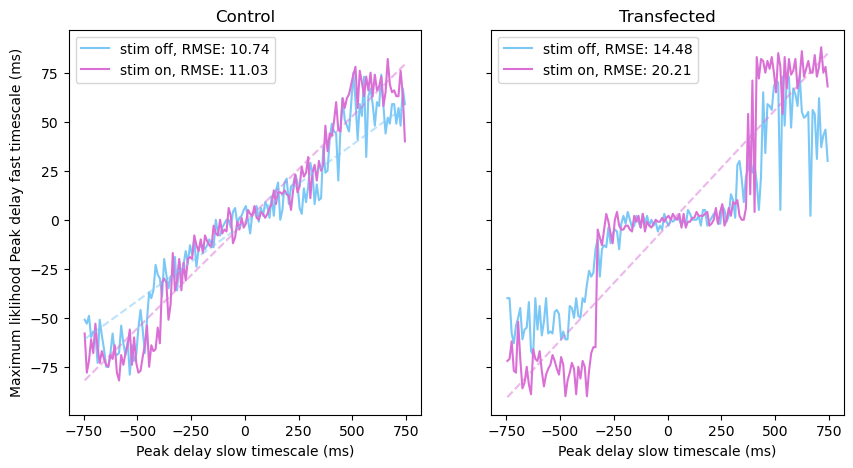

In [26]:
from ms_stim_analysis.Style.style_guide import interval_style

fig, ax = plt.subplots(figsize=(10, 5), ncols=2, sharey=True)
for animal in ["control", "transfected"]:
    for cond in ["stim off", "stim on"]:
        color = (
            interval_style["control"] if cond == "stim off" else interval_style["test"]
        )

        H = heatmap_results[animal][cond]
        bx = np.arange(-correlation_range, correlation_range + 1, slow_bin_size)
        by = np.arange(-200, 200, fast_bin_size)
        b_plot = bx[:-1] + slow_bin_size / 2  # center the bins

        ridge = by[np.argmax(H, axis=1)]
        d_ridge = np.diff(ridge)

        lin_fit = np.polyfit(b_plot, ridge, 1)
        a.plot(
            b_plot, np.polyval(lin_fit, b_plot), linestyle="--", color=color, alpha=0.5
        )
        rmse = np.sqrt(np.mean((ridge - np.polyval(lin_fit, b_plot)) ** 2))
        print(f"{animal} {cond} RMSE: {rmse:.2f}")

        a = ax[0] if animal == "control" else ax[1]
        a.plot(b_plot, ridge, label=f"{cond}, RMSE: {rmse:.2f}", color=color)

ax[0].set_title("Control")
ax[1].set_title("Transfected")
ax[0].set_ylabel("Maximum liklihood Peak delay fast timescale (ms)")
ax[1].set_xlabel("Peak delay slow timescale (ms)")
ax[0].set_xlabel("Peak delay slow timescale (ms)")
ax[0].legend()
ax[1].legend()

# Heirarchical Bootstrap Correlation Coefficients

In [28]:
correlation_range = 200
fast_correlation_range = 99
n_boot = 1000

animal_groups = {
    "control": [
        "Yoshi",
        "Wallie",
        # "Bilbo",
        # "Olive",
    ],
    "targeted": [
        "Winnie",
        # "Frodo",
        "Totoro",
    ],
}

In [29]:
from tqdm import tqdm

bootstrap_results = {}

for group, animals in animal_groups.items():
    bootstrap_results[group] = {}
    for cond in ["control", "test"]:
        temp_results = {}
        for animal in animals:
            df = results[animal][cond].copy()
            # df = df[np.logical_and(
            #     np.abs(df.peak_delay_fast) < fast_correlation_range,
            #     np.abs(df.peak_delay_slow) < correlation_range
            #     )
            #         ]
            slow_val = df.peak_delay_slow.values.copy()
            fast_val = np.array(
                [get_max_fast_peak_delay(row) for _, row in df.iterrows()]
            )
            # fast_val = fast_val%100

            ind_valid = np.logical_and(
                np.abs(slow_val) < correlation_range,
                np.abs(fast_val) < fast_correlation_range,
            )
            df = pd.DataFrame(
                {
                    "peak_delay_slow": slow_val[ind_valid],
                    "peak_delay_fast": fast_val[ind_valid],
                }
            )

            temp_results[animal] = df

        c_ = []
        for _ in tqdm(range(n_boot), desc=f"Bootstrapping {group} {cond}"):
            animal_samples = np.random.choice(animals, len(animals), replace=True)
            slow_val = []
            fast_val = []
            for animal in animal_samples:
                df = temp_results[animal]
                pair_samples = np.random.choice(len(df), len(df), replace=True)
                slow_val.extend(df.peak_delay_slow.values[pair_samples])
                fast_val.extend(df.peak_delay_fast.values[pair_samples])
            corr = np.corrcoef(slow_val, fast_val)[0, 1]
            c_.append(corr)
        c_ = np.array(c_)
        bootstrap_results[group][cond] = c_

Bootstrapping targeted test: 100%|██████████| 1000/1000 [00:00<00:00, 1180.48it/s]


interval effect (control animals) p-value: 0.430
interval effect (targeted animals) p-value: 0.205
group effect (control interval) p-value: 0.004
group effect (test interval) p-value: 0.091


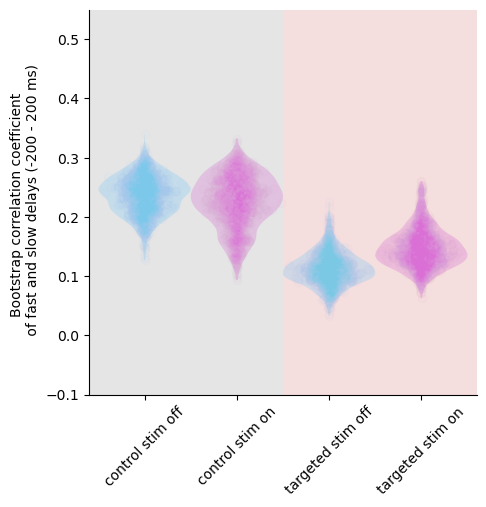

In [31]:
ticks = []
labels = []
from ms_stim_analysis.Style.style_guide import interval_style
from ms_stim_analysis.Analysis.utils import violin_scatter

fig = plt.figure(figsize=(5, 5))
for i, group in enumerate(bootstrap_results):
    for j, cond in enumerate(bootstrap_results[group]):
        scores = bootstrap_results[group][cond]
        color = (
            interval_style["control"] if cond == "control" else interval_style["test"]
        )
        cond_name = "stim off" if cond == "control" else "stim on"
        xloc = i + j * 0.5
        violin_scatter(scores, pos=[xloc], color=color)
        ticks.append(xloc)
        labels.append(f"{group} {cond_name}")


def test_diff_of_bootstrap_dist(dist1, dist2):
    diff = np.subtract.outer(dist1, dist2)
    diff = np.ravel(diff)
    # standarize the sign of the difference
    if np.mean(diff) < 0:
        diff = -diff
    p_val = np.sum(diff < 0) / diff.size
    return p_val


# test for interval driven difference in each animal group
for i, group in enumerate(bootstrap_results):
    dists = [bootstrap_results[group]["control"], bootstrap_results[group]["test"]]
    p_val = test_diff_of_bootstrap_dist(*dists)
    print(f"interval effect ({group} animals) p-value: {p_val:.3f}")
# test for difference between control and transfected for each interval
for i, cond in enumerate(["control", "test"]):
    dists = [
        bootstrap_results["control"][cond],
        bootstrap_results["targeted"][cond],
    ]
    p_val = test_diff_of_bootstrap_dist(*dists)
    print(f"group effect ({cond} interval) p-value: {p_val:.3f}")


# # indicate sig difference
# y_max = 0.42
# y_bridge = 0.45
# x1 = ticks[1]
# x2 = ticks[3]
# bar_rng = 0.12
# plt.plot([x1, x2], [y_bridge, y_bridge], color="k", lw=1)
# plt.plot([x1, x1], [y_max, y_bridge], color="k", lw=1)
# plt.plot([x2, x2], [y_max, y_bridge], color="k", lw=1)
# plt.plot([x1 - bar_rng, x1 + bar_rng], [y_max, y_max], color="k", lw=1)
# plt.plot([x2 - bar_rng, x2 + bar_rng], [y_max, y_max], color="k", lw=1)
# plt.text(
#     x1 + (x2 - x1) * 0.65,
#     y_bridge + 0.02,
#     "* p < 0.05",
#     ha="left",
#     va="center",
#     fontsize=10,
#     color="k",
# )

# # indicate sig difference
# y_max = 0.42, 0.47
# y_bridge = 0.50
# x1 = ticks[0]
# x2 = ticks[2]
# plt.plot([x1, x2], [y_bridge, y_bridge], color="k", lw=1)
# plt.plot([x1, x1], [y_max[0], y_bridge], color="k", lw=1)
# plt.plot([x2, x2], [y_max[1], y_bridge], color="k", lw=1)
# plt.plot([x1 - bar_rng, x1 + bar_rng], [y_max[0], y_max[0]], color="k", lw=1)
# plt.plot([x2 - bar_rng, x2 + bar_rng], [y_max[1], y_max[1]], color="k", lw=1)
# plt.text(
#     (x1 + x2) / 2,
#     y_bridge + 0.02,
#     "* p < 0.05",
#     ha="center",
#     va="center",
#     fontsize=10,
#     color="k",
# )


plt.xticks(ticks, labels, rotation=45)
plt.ylabel(
    f"Bootstrap correlation coefficient \n of fast and slow delays ({-correlation_range} - {correlation_range} ms)"
)
plt.xlim(-0.3, len(ticks) / 2 - 0.2)

plt.fill_between(
    [-1, 0.75],
    -0.2,
    0.6,
    facecolor=animal_style.loc["control", "color"],
    alpha=0.2,
    zorder=-1,
)
plt.fill_between(
    [0.75, 2.25],
    -0.2,
    0.6,
    facecolor=animal_style.loc["transfected", "color"],
    alpha=0.2,
    zorder=-1,
)
plt.ylim(-0.1, 0.55)

fig.gca().spines[["top", "right"]].set_visible(False)

plt.rcParams["svg.fonttype"] = "none"
plt.rcParams["font.family"] = "Arial"
# fig.savefig(
#     "/home/sambray/Documents/MS_analysis_samsplaying/Figures_20250501/lineartrack_bootstrap_correlation_coefficients_WITHOlive.pdf"
# )

# Plot Examples

(-1000.0, 1000.0)

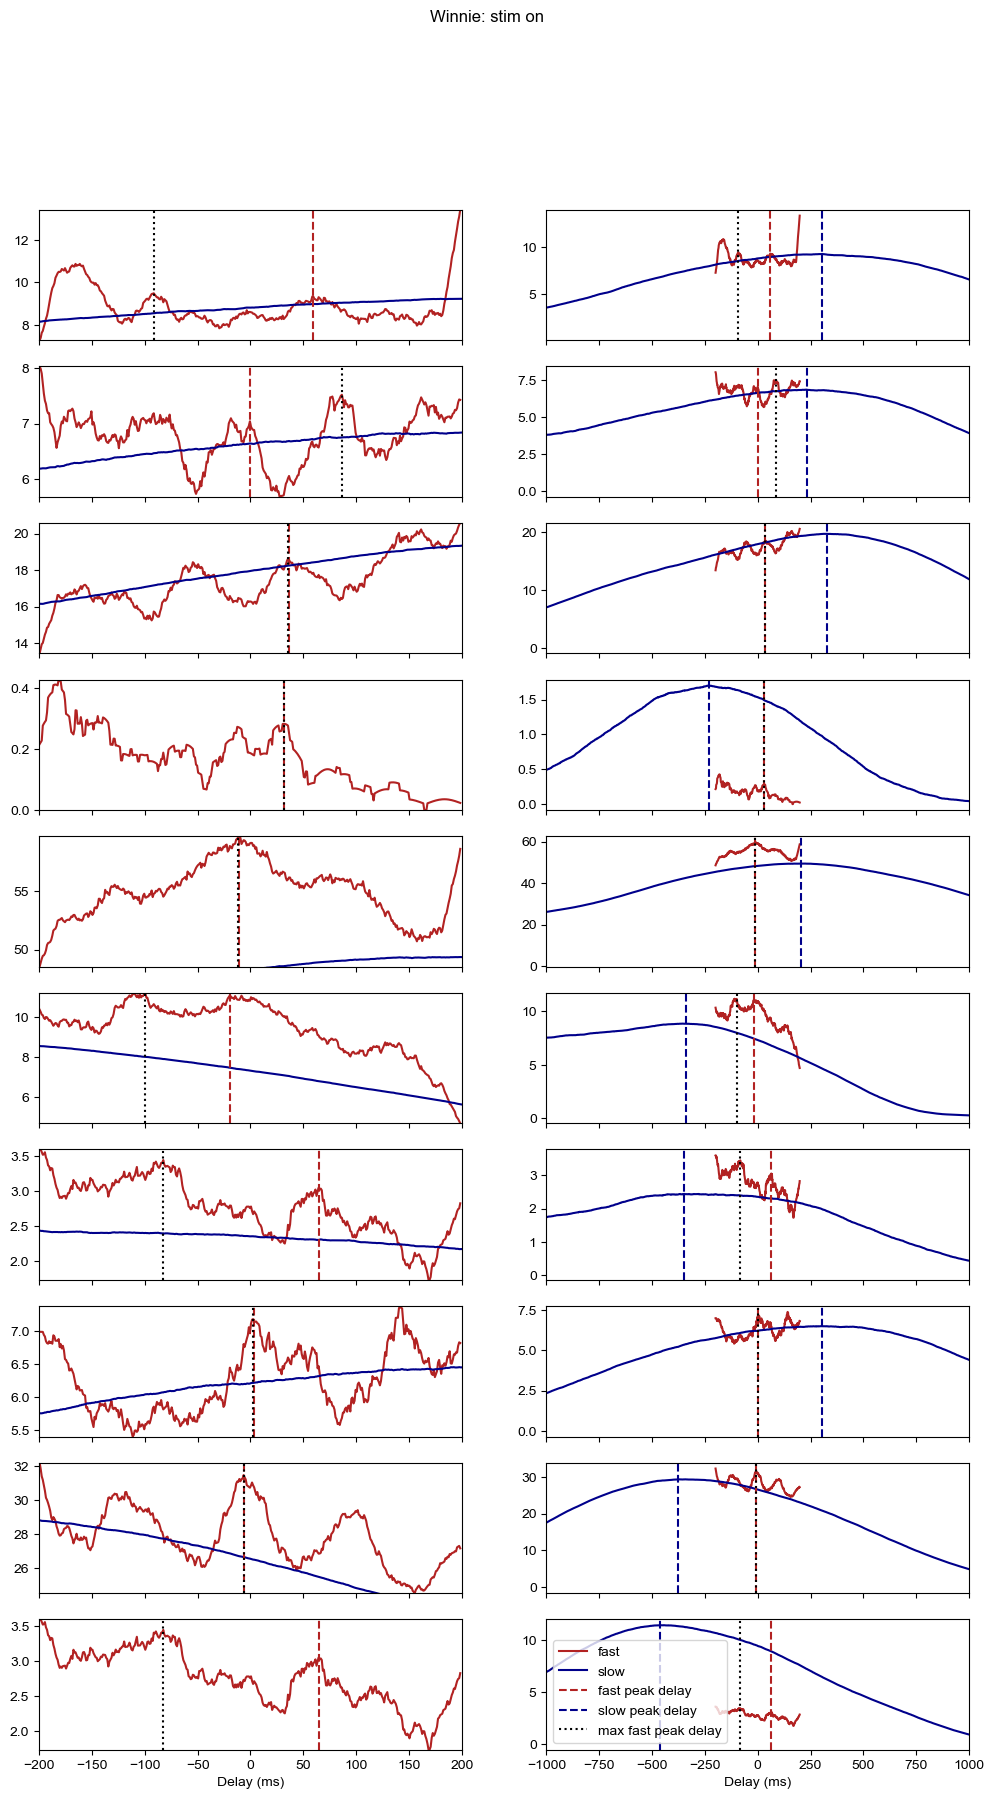

In [ ]:
animal = "Winnie"
df = results[animal]["test"]
# df = df[df.peak_delay_slow.abs() >400 ]
# df = df[df.peak_delay_slow.abs() < 1000]
df = df[df.peak_delay_slow.abs() > 200]
df = df[df.peak_delay_slow.abs() < 500]

slow_bins = np.arange(-3000, 2999) + 0.5
fast_bins = np.arange(-200, 199) + 0.5
fast_color = "firebrick"
slow_color = "darkblue"


fig, ax_array = plt.subplots(nrows=10, ncols=2, sharex="col", figsize=(12, 20))
np.random.seed(1)
for j, pair_i in enumerate(np.random.choice(len(df), 10, replace=False)):
    ax = ax_array[j]
    row = df.iloc[pair_i]
    for i in range(2):
        ax[i].plot(fast_bins, row.cross_corr_fast, label="fast", color=fast_color)
        ax[i].plot(slow_bins, row.cross_corr_slow, label="slow", color=slow_color)
        ax[i].axvline(
            row.peak_delay_fast, ls="--", label="fast peak delay", color=fast_color
        )
        ax[i].axvline(
            row.peak_delay_slow, ls="--", label="slow peak delay", color=slow_color
        )
        ax[i].axvline(
            get_max_fast_peak_delay(row), ls=":", label="max fast peak delay", color="k"
        )
    ax[0].set_ylim(row.cross_corr_fast.min(), row.cross_corr_fast.max())

ax[0].set_xlim(-200, 200)
ax[1].set_xlim(-1000, 1000)
ax[1].set_xlim(-2000, 2000)
ax[0].set_xlabel("Delay (ms)")
ax[1].set_xlabel("Delay (ms)")
# plt.xlim(-500, 500)
plt.legend()
fig.suptitle(f"{animal}: stim on ")
plt.xlim(-1000, 1000)

# Fast-Fast consitency

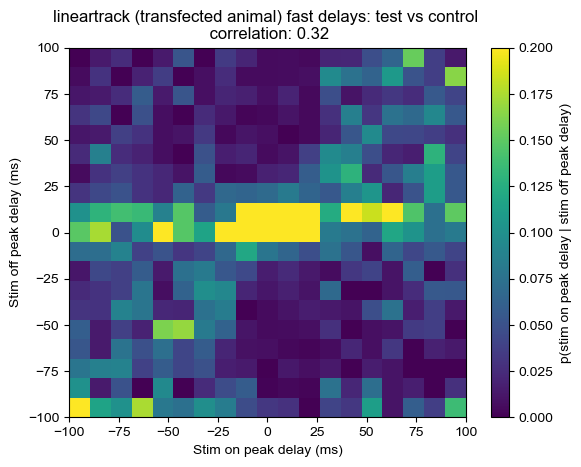

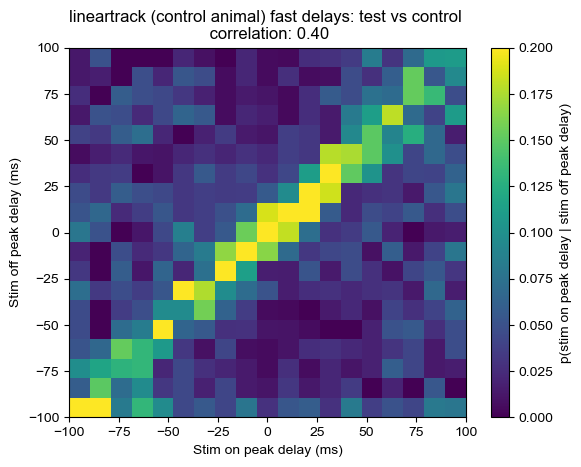

In [ ]:
for animal in ["transfected", "control"]:
    min_coincidients = 50
    fig = plt.figure()
    merged_df = pd.merge(
        results[animal]["test"],
        results[animal]["control"],
        how="inner",
        on=["s_id_1", "s_id_2"],
    )
    merged_df = merged_df[
        np.logical_and(
            merged_df.n_coincidients_fast_x > min_coincidients,
            merged_df.n_coincidients_fast_y > min_coincidients,
        )
    ]

    test_df = merged_df.copy()
    test_df = test_df.rename(
        columns={
            "cross_corr_fast_x": "cross_corr_fast",
        }
    )
    test_delays = np.array(
        [get_max_fast_peak_delay(row) for _, row in test_df.iterrows()]
    )

    control_df = merged_df.copy()
    control_df = control_df.rename(
        columns={
            "cross_corr_fast_y": "cross_corr_fast",
        }
    )
    control_delays = np.array(
        [get_max_fast_peak_delay(row) for _, row in control_df.iterrows()]
    )

    # plt.scatter(test_delays, control_delays, alpha=0.2)
    H = np.histogram2d(
        control_delays,
        test_delays,
        bins=(np.arange(-100, 100, 10), np.arange(-100, 100, 10)),
    )[0]
    H = H / H.sum(axis=1)[:, None]  #
    # H = H/H.sum()

    plt.imshow(
        H.T,
        origin="lower",
        extent=(-100, 100, -100, 100),
        # cmap="Blues",
        aspect="auto",
        clim=(0, 0.2),
    )
    plt.colorbar(label="p(stim on peak delay | stim off peak delay)")
    np.corrcoef(test_delays, control_delays)[0, 1]

    plt.title(
        f"{track} ({animal} animal) fast delays: test vs control \n correlation: {np.corrcoef(test_delays, control_delays)[0, 1]:.2f}"
    )

    plt.xlabel("Stim on peak delay (ms)")
    plt.ylabel("Stim off peak delay (ms)")

    fig.savefig(
        f"../Figures/Fig_2/Fig_2d_fast_peak_delay_test_vs_control_{animal}_animals.svg"
    )

In [19]:
n_boot = 10000

animal_groups = {
    "control": [
        "Yoshi",
        "Wallie",
        # "Bilbo",
        # "Olive",
    ],
    "targeted": [
        "Winnie",
        # "Frodo",
        "Totoro",
    ],
}


def test_diff_of_bootstrap_dist(dist1, dist2):
    diff = np.subtract.outer(dist1, dist2)
    diff = np.ravel(diff)
    # standarize the sign of the difference
    if np.mean(diff) < 0:
        diff = -diff
    p_val = np.sum(diff < 0) / diff.size
    return p_val

In [18]:
from tqdm import tqdm

bootstrap_results = {}

for group, animals in animal_groups.items():
    # bootstrap_results[group] = {}

    temp_results = {}
    for animal in animals:
        merged_df = pd.merge(
            results[animal]["test"],
            results[animal]["control"],
            how="inner",
            on=["s_id_1", "s_id_2"],
        )

        test_df = merged_df.copy()
        test_df = test_df.rename(
            columns={
                "cross_corr_fast_x": "cross_corr_fast",
            }
        )
        test_delays = np.array(
            [get_max_fast_peak_delay(row) for _, row in test_df.iterrows()]
        )

        control_df = merged_df.copy()
        control_df = control_df.rename(
            columns={
                "cross_corr_fast_y": "cross_corr_fast",
            }
        )
        control_delays = np.array(
            [get_max_fast_peak_delay(row) for _, row in control_df.iterrows()]
        )

        df = pd.DataFrame(
            {
                "control_delays": control_delays,
                "test_delays": test_delays,
            }
        )

        temp_results[animal] = df

    c_ = []
    for _ in tqdm(range(n_boot), desc=f"Bootstrapping {group} "):
        animal_samples = np.random.choice(animals, len(animals), replace=True)
        control_val = []
        test_val = []
        for animal in animal_samples:
            df = temp_results[animal]
            pair_samples = np.random.choice(len(df), len(df), replace=True)
            control_val.extend(df.control_delays.values[pair_samples])
            test_val.extend(df.test_delays.values[pair_samples])
        corr = np.corrcoef(control_val, test_val)[0, 1]
        c_.append(corr)
    c_ = np.array(c_)
    bootstrap_results[group] = c_

Bootstrapping targeted : 100%|██████████| 10000/10000 [00:10<00:00, 914.22it/s]


0.15253848

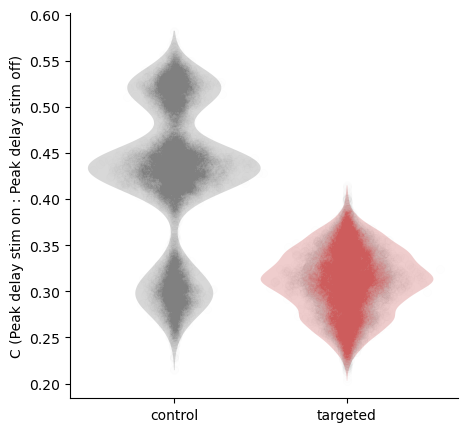

In [22]:
from Analysis.utils import violin_scatter

fig = plt.figure(figsize=(5, 5))
for animal in bootstrap_results:
    scores = bootstrap_results[animal]
    # color = animal_style.loc[animal, "color"]
    xloc = 0 if animal == "control" else 0.5
    color = (
        animal_style.loc["control", "color"]
        if animal == "control"
        else animal_style.loc["transfected", "color"]
    )
    violin_scatter(scores, pos=[xloc], color=color)
    # ticks.append(xloc)
    # labels.append(animal)
plt.xticks([0, 0.5], ["control", "targeted"], rotation=0)
ax = fig.gca()
ax.spines[["top", "right"]].set_visible(False)
ax.set_ylabel("C (Peak delay stim on : Peak delay stim off)")

# ybar = 0.35
# plt.plot(
#     [-0.1, 0.6],
#     [ybar, ybar],
#     color="k",
#     lw=1,
# )
# plt.text(
#     0.25,
#     ybar + 0.01,
#     "* p < 0.05",
#     ha="center",
#     va="center",
#     fontsize=10,
#     color="k",
# )

# fig.savefig(
#     "/home/sambray/Documents/MS_analysis_samsplaying/Figures_20250501/lineartrack_fast_fast_bootstrap_correlation_coefficients_Excludeanimals.svg"
# )

test_diff_of_bootstrap_dist(bootstrap_results["control"], bootstrap_results["targeted"])

### Non-heirarchical bootstrap

In [ ]:
from tqdm import tqdm

bootstrap_results = {}
n_boot = 10000


for animal in ["control", "transfected"]:
    df = results[animal]["test"]
    merged_df = pd.merge(
        results[animal]["test"],
        results[animal]["control"],
        how="inner",
        on=["s_id_1", "s_id_2"],
    )

    test_df = merged_df.copy()
    test_df = test_df.rename(
        columns={
            "cross_corr_fast_x": "cross_corr_fast",
        }
    )
    test_delays = np.array(
        [get_max_fast_peak_delay(row) for _, row in test_df.iterrows()]
    )

    control_df = merged_df.copy()
    control_df = control_df.rename(
        columns={
            "cross_corr_fast_y": "cross_corr_fast",
        }
    )
    control_delays = np.array(
        [get_max_fast_peak_delay(row) for _, row in control_df.iterrows()]
    )

    df = pd.DataFrame(
        {
            "control_delays": control_delays,
            "test_delays": test_delays,
        }
    )

    c_ = []
    for _ in tqdm(range(n_boot), desc=f"Bootstrapping {animal} "):
        pair_samples = np.random.choice(len(df), len(df), replace=True)
        control_val = df.control_delays.values[pair_samples]
        test_val = df.test_delays.values[pair_samples]
        corr = np.corrcoef(control_val, test_val)[0, 1]
        c_.append(corr)
    c_ = np.array(c_)
    bootstrap_results[animal] = c_

Bootstrapping transfected : 100%|██████████| 10000/10000 [00:02<00:00, 4536.74it/s]


0.00012743

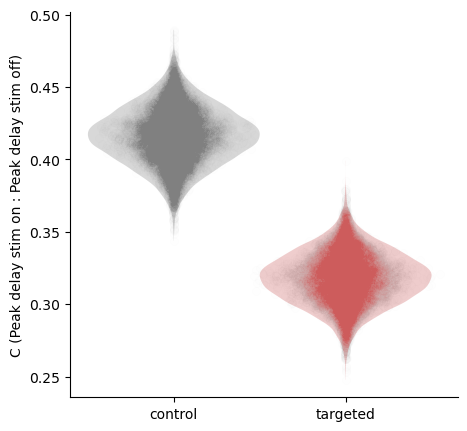

In [ ]:
from Analysis.utils import violin_scatter

fig = plt.figure(figsize=(5, 5))
for animal in bootstrap_results:
    scores = bootstrap_results[animal]
    # color = animal_style.loc[animal, "color"]
    xloc = 0 if animal == "control" else 0.5
    color = (
        animal_style.loc["control", "color"]
        if animal == "control"
        else animal_style.loc["transfected", "color"]
    )
    violin_scatter(scores, pos=[xloc], color=color)
    # ticks.append(xloc)
    # labels.append(animal)
plt.xticks([0, 0.5], ["control", "targeted"], rotation=0)
ax = fig.gca()
ax.spines[["top", "right"]].set_visible(False)
ax.set_ylabel("C (Peak delay stim on : Peak delay stim off)")

# ybar = 0.35
# plt.plot(
#     [-0.1, 0.6],
#     [ybar, ybar],
#     color="k",
#     lw=1,
# )
# plt.text(
#     0.25,
#     ybar + 0.01,
#     "* p < 0.05",
#     ha="center",
#     va="center",
#     fontsize=10,
#     color="k",
# )

# fig.savefig(
#     "/home/sambray/Documents/MS_analysis_samsplaying/Figures_20250501/lineartrack_fast_fast_bootstrap_correlation_coefficients_Excludeanimals.svg"
# )
fig.savefig(
    "/home/sambray/Documents/MS_analysis_samsplaying/Figures202507/lineartrack_fast_fast_NonHierarchical_bootstrap_correlation_coefficients_Excludeanimals.svg"
)

test_diff_of_bootstrap_dist(
    bootstrap_results["control"], bootstrap_results["transfected"]
)

0.00012743

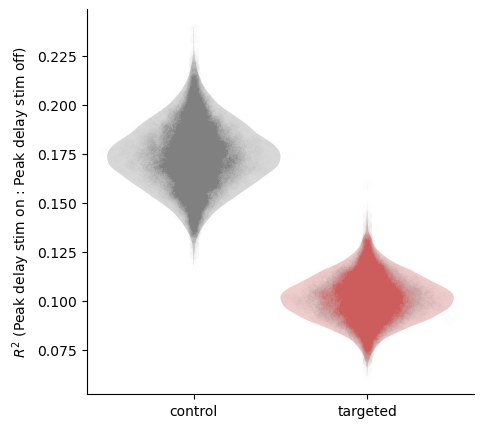

In [ ]:
from Analysis.utils import violin_scatter

fig = plt.figure(figsize=(5, 5))
for animal in bootstrap_results:
    scores = bootstrap_results[animal] ** 2
    # color = animal_style.loc[animal, "color"]
    xloc = 0 if animal == "control" else 0.5
    color = (
        animal_style.loc["control", "color"]
        if animal == "control"
        else animal_style.loc["transfected", "color"]
    )
    violin_scatter(scores, pos=[xloc], color=color)
    # ticks.append(xloc)
    # labels.append(animal)
plt.xticks([0, 0.5], ["control", "targeted"], rotation=0)
ax = fig.gca()
ax.spines[["top", "right"]].set_visible(False)
ax.set_ylabel("$R^2$ (Peak delay stim on : Peak delay stim off)")

# ybar = 0.35
# plt.plot(
#     [-0.1, 0.6],
#     [ybar, ybar],
#     color="k",
#     lw=1,
# )
# plt.text(
#     0.25,
#     ybar + 0.01,
#     "* p < 0.05",
#     ha="center",
#     va="center",
#     fontsize=10,
#     color="k",
# )

# fig.savefig(
#     "/home/sambray/Documents/MS_analysis_samsplaying/Figures_20250501/lineartrack_fast_fast_bootstrap_correlation_coefficients_Excludeanimals.svg"
# )
fig.savefig(
    "/home/sambray/Documents/MS_analysis_samsplaying/Figures202507/lineartrack_fast_fast_NonHierarchical_bootstrap_R2_Excludeanimals.svg"
)

test_diff_of_bootstrap_dist(
    bootstrap_results["control"], bootstrap_results["transfected"]
)